# Stage 13 Homework Starter — Productization

## Objective
Deploy your trained model as a **reusable, handoff-ready API or dashboard** and finalize your project for reproducibility and clarity.

## Steps
1. Create a mock, very basic analysis in a notebook.
2. Clean your notebook by removing exploratory cells and documenting your code.
3. Move reusable functions into `/src/`.
4. Load your trained model from Stage 12 or earlier stages.
5. Pickle/save the model and test reload.
6. Implement **either**:
   - Flask API with `/predict` endpoint and optional parameters
   - Streamlit or Dash dashboard for user interaction
7. Include:
   - Error handling for invalid inputs
   - `requirements.txt` for reproducibility
   - Documentation in `README.md`
8. Test your deployment locally and provide evidence.
9. Organize project folders and finalize notebooks for handoff.

## 1. Create mock, very basic analysis

,date,nvda_price,change in price,rolling_price
0,2025-02-18,139.377502,0.000000,139.377502
1,2025-02-19,139.207520,-0.169983,139.292511
2,2025-02-20,140.087387,0.879868,139.557470
3,2025-02-21,134.408295,-5.679092,138.270176
4,2025-02-24,130.258972,-4.149323,136.667935
...,...,...,...,...
120,2025-08-11,182.059998,-0.639999,175.512000
121,2025-08-12,183.160004,1.100006,176.135000
122,2025-08-13,181.589996,-1.570007,176.646000
123,2025-08-14,182.020004,0.430008,177.097000


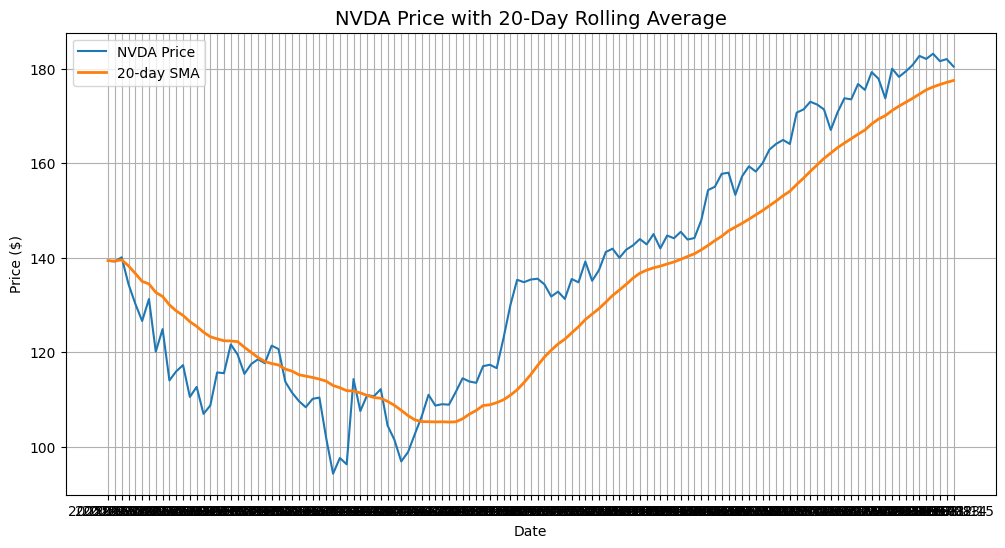

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import pickle

df= pd.read_csv("../../../project/data/raw/api_yfinance_nvda_20250218-0815.csv")
df = df.rename(columns={'date': 'date', 'adj_close': 'nvda_price'})
df.head()


df['change in price'] = df['nvda_price'].diff().fillna(0) 
df['rolling_price'] = df['nvda_price'].rolling(20, min_periods=1).mean()
display(df)
plt.figure(figsize=(12,6))
plt.plot(df['date'], df['nvda_price'], label='NVDA Price', linewidth=1.5)
plt.plot(df['date'], df['rolling_price'], label='20-day SMA', linewidth=2)

plt.title("NVDA Price with 20-Day Rolling Average", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()

## 2. Notebook Cleanup
Remove exploratory cells and document your code.

,date,nvda_price,change_in_price,rolling_price
0,2025-02-18,139.377502,0.000000,139.377502
1,2025-02-19,139.207520,-0.169983,139.292511
2,2025-02-20,140.087387,0.879868,139.557470
3,2025-02-21,134.408295,-5.679092,138.270176
4,2025-02-24,130.258972,-4.149323,136.667935


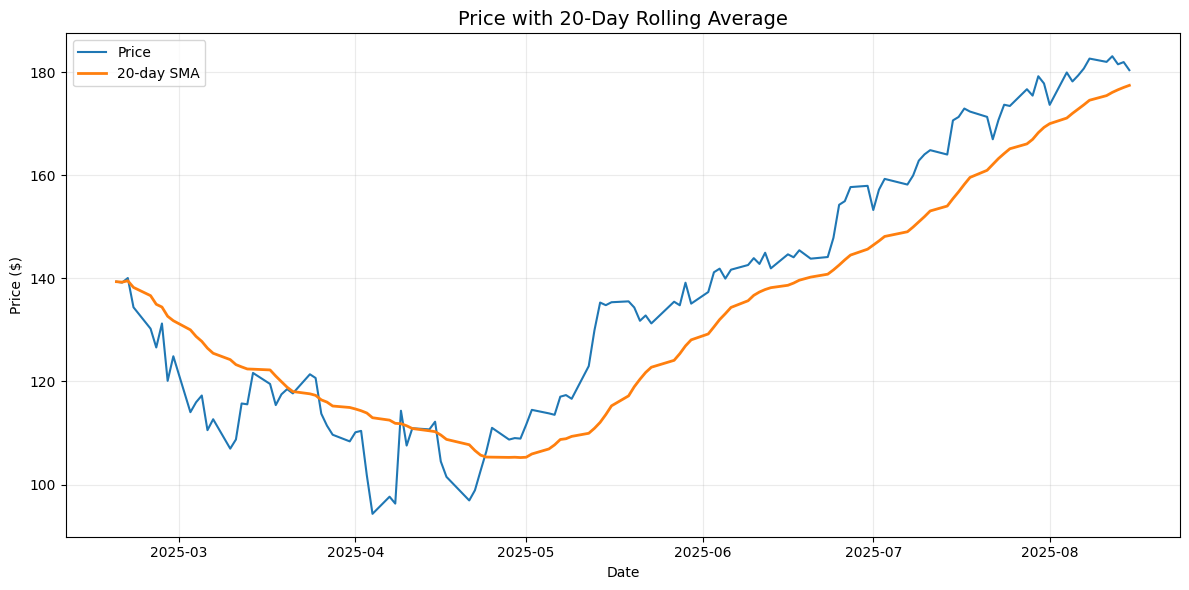

,date,nvda_price,change_in_price,rolling_price
0,2025-02-18,139.377502,0.000000,139.377502
1,2025-02-19,139.207520,-0.169983,139.292511
2,2025-02-20,140.087387,0.879868,139.557470
3,2025-02-21,134.408295,-5.679092,138.270176
4,2025-02-24,130.258972,-4.149323,136.667935


In [19]:
df= pd.read_csv("../../../project/data/raw/api_yfinance_nvda_20250218-0815.csv")
df = df.rename(columns={'date': 'date', 'adj_close': 'nvda_price'})
df = add_feature_and_plot(df, price_col='nvda_price', date_col='date', window=20)
df.head()

Different from the original graph due to adjustment on missing values. 

## 3. Move reusable functions to /src/
Create src/utils.py and store functions there.

In [18]:
def add_feature_and_plot(df, price_col, date_col, window=20):
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col]).sort_values(date_col)
    df['change_in_price'] = df[price_col].diff().fillna(0)
    df['rolling_price'] = df[price_col].rolling(window, min_periods=1).mean()
    display(df.head())
    plt.figure(figsize=(12,6))
    plt.plot(df[date_col], df[price_col], label='Price', linewidth=1.5)
    plt.plot(df[date_col], df['rolling_price'], label=f'{window}-day SMA', linewidth=2)
    plt.title("Price with 20-Day Rolling Average", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()
    return df
# already moved  

## 4. Folder Structure Reminder

Ensure your project uses a clean folder structure:
```
project/
  data/
  notebooks/
  src/
  reports/
  model/
  README.md
```
For API/Dashboard: minimal example:
```
project/
    app.py
    model.pkl
    requirements.txt
    README.md
```

In [29]:
print(df)
#Start my model
df['lag_1']  = df['change in price'].shift(1)
df['y_next_ret'] = df['change in price'].shift(-1)
df_feat = df.dropna(subset=['lag_1','y_next_ret']).copy()
X = df_feat[['lag_1']].values           
y = df_feat['y_next_ret'].values      
model = LinearRegression().fit(X, y)
FEATURES = ['lag_1']           
TARGET   = 'y_next_ret'
df_feat = df.dropna(subset=FEATURES + [TARGET]).copy()
X = df_feat[FEATURES].values   
y = df_feat[TARGET].values
split = int(len(df_feat) * 0.8)
X_tr, y_tr = X[:split], y[:split]
X_te, y_te = X[split:], y[split:]
model = LinearRegression().fit(X_tr, y_tr)
bundle = {"model": model, "features": FEATURES, "target": TARGET}
os.makedirs('model', exist_ok=True)
with open('model/model.pkl', 'wb') as f:
    pickle.dump(bundle, f)

           date  nvda_price  change in price  rolling_price
0    2025-02-18  139.377502         0.000000     139.377502
1    2025-02-19  139.207520        -0.169983     139.292511
2    2025-02-20  140.087387         0.879868     139.557470
3    2025-02-21  134.408295        -5.679092     138.270176
4    2025-02-24  130.258972        -4.149323     136.667935
..          ...         ...              ...            ...
120  2025-08-11  182.059998        -0.639999     175.512000
121  2025-08-12  183.160004         1.100006     176.135000
122  2025-08-13  181.589996        -1.570007     176.646000
123  2025-08-14  182.020004         0.430008     177.097000
124  2025-08-15  180.449997        -1.570007     177.499000

[125 rows x 4 columns]


## 5. Pickle / Save Final Model

### TODO: Replace this with your trained model

In [40]:

# TODO: Replace 'model' with your trained model variable
save_path = '../model/model.pkl'   
os.makedirs(os.path.dirname(save_path), exist_ok=True) 

with open('model/model.pkl', 'wb') as f:
    pickle.dump(model, f)

# TODO: Test loading the model
with open('model/model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Example prediction (replace with actual features)
print(loaded_model.predict(np.array([[0.1]], dtype=float))[0])

0.23376268496798447


## 6. Flask API Starter

### TODO: Implement Flask endpoints for /predict and /plot

In [ ]:
from flask import Flask, request, jsonify
import threading
import matplotlib.pyplot as plt
import io
import base64

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    # TODO: Replace placeholder logic with actual model prediction
    data = request.get_json()
    features = data.get('features', None)
    if features is None:
        return jsonify({'error': 'No features provided'}), 400
    pred = sum(features)  # placeholder
    return jsonify({'prediction': pred})

@app.route('/predict/<float:input1>', methods=['GET'])
def predict_one(input1):
    pred = input1 * 2  # placeholder
    return jsonify({'prediction': pred})

@app.route('/predict/<float:input1>/<float:input2>', methods=['GET'])
def predict_two(input1, input2):
    pred = input1 + input2  # placeholder
    return jsonify({'prediction': pred})

@app.route('/plot')
def plot():
    # TODO: Replace with meaningful chart or image
    fig, ax = plt.subplots()
    ax.plot([0, 1, 2], [0, 1, 4])
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    img_bytes = base64.b64encode(buf.read()).decode('utf-8')
    return f'<img src="data:image/png;base64,{img_bytes}"/>'

def run_flask():
    app.run(port=5000)

# Launch Flask in a separate thread
threading.Thread(target=run_flask).start()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [27/Aug/2025 22:01:26] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [27/Aug/2025 22:01:26] "GET /predict/2.0 HTTP/1.1" 200 -
127.0.0.1 - - [27/Aug/2025 22:01:26] "GET /predict/1.0/3.0 HTTP/1.1" 200 -
127.0.0.1 - - [27/Aug/2025 22:01:26] "GET /plot HTTP/1.1" 200 -
127.0.0.1 - - [27/Aug/2025 22:10:31] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [27/Aug/2025 22:10:31] "GET /predict/2.0 HTTP/1.1" 200 -
127.0.0.1 - - [27/Aug/2025 22:10:31] "GET /predict/1.0/3.0 HTTP/1.1" 200 -
127.0.0.1 - - [27/Aug/2025 22:10:31] "GET /plot HTTP/1.1" 200 -
127.0.0.1 - - [27/Aug/2025 22:12:04] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [27/Aug/2025 22:12:04] "GET /predict/2.0 HTTP/1.1" 200 -
127.0.0.1 - - [27/Aug/2025 22:12:04] "GET /predict/1.0/3.0 HTTP/1.1" 200 -
127.0.0.1 - - [27/Aug/2025 22:12:04] "GET /plot HTTP/1.1" 200 -


## 7. Testing the Flask API from Notebook

### TODO: Modify examples with your actual features

{'prediction': 0.6000000000000001}
{'prediction': 4.0}
{'prediction': 4.0}



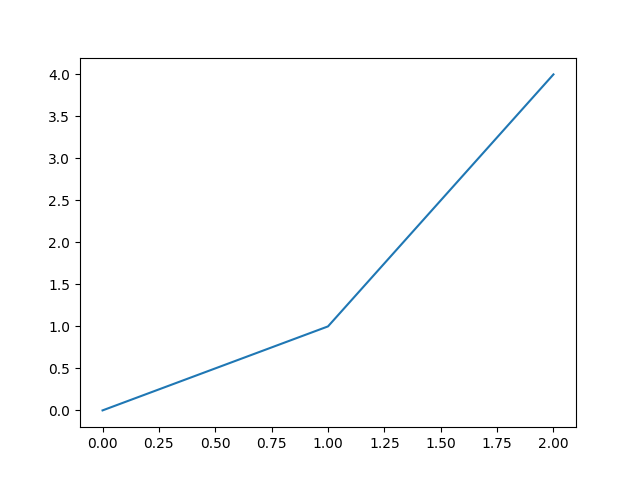

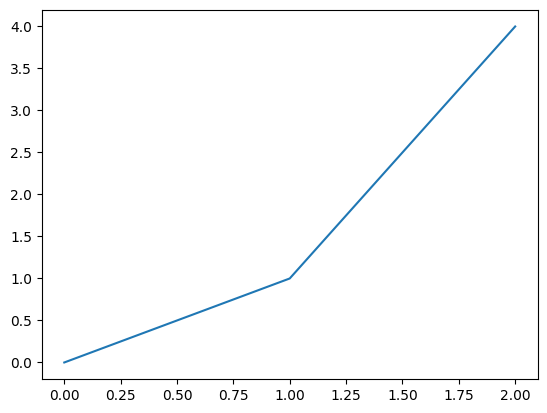

In [ ]:
import requests
from IPython.display import display, HTML

try:
    features = [0.1, 0.2, 0.3]  # edit as needed
    if not all(isinstance(x, (int, float)) for x in features):
        raise ValueError("`features` must be numbers.")
    r = requests.post("http://127.0.0.1:5000/predict", json={"features": features}, timeout=10)
    r.raise_for_status()
    try: print(r.json())
    except ValueError: print(r.text)
except Exception as e:
    print("[POST /predict error]", e)
# GET /predict/<input1>
response2 = requests.get('http://127.0.0.1:5000/predict/2.0')
print(response2.json())

# GET /predict/<input1>/<input2>
response3 = requests.get('http://127.0.0.1:5000/predict/1.0/3.0')
print(response3.json())

# GET /plot
response_plot = requests.get('http://127.0.0.1:5000/plot')
display(HTML(response_plot.text))


## 8. Optional Streamlit / Dash Dashboard

### TODO: Add dashboard in a separate file (`app_streamlit.py` or `app_dash.py`)

## 9. Handoff Best Practices

- Ensure README.md is complete and clear
- Provide `requirements.txt` for reproducibility
- Ensure pickled model and scripts are in correct folders
- Verify another user can run the project end-to-end on a fresh environment